In [377]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import random

## Global Variables

You can play around with `num_demand_points` and `coverage_radius` to see how the solution changes.

In [378]:
# Set the dimensions of the rectangular region
region_width = 100
region_height = 100

# Set the number of demand points
num_demand_points = 20

# Set the coverage radius of a UAV
coverage_radius = 30

# Graph config
figsize=(8,6)
label_font_size=12
node_size=500


## Data Generation
Data is generated with a random integer `x` and `y` coordinate between `0` and the bounds of the region (`region_width` and `region_height`).

In [379]:
# Create an empty graph
G = nx.Graph()

# Generate random positions for demand points within the rectangular region
demand_points = []
for i in range(num_demand_points):
    x = random.randint(0, region_width)
    y = random.randint(0, region_height)
    demand_points.append((x, y))
    G.add_node(i, pos=(x, y)) 

print ("G has", G.number_of_nodes(), "nodes")

G has 20 nodes


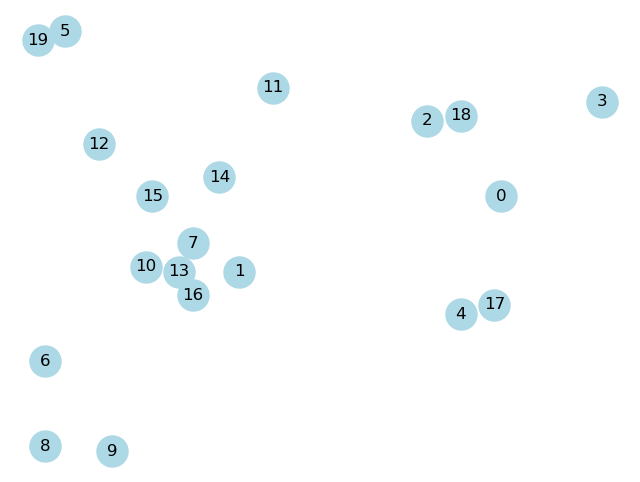

In [380]:
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=figsize)
nx.draw_networkx_labels(G, pos, font_size=label_font_size)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_size)
nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.show()

### Sets
- $N$ = set of demand points
- $M$ = set of flight position of UAVs

### Parameters
- $b^x_j$ = flight position of UAV $j$ on x-coordinate
- $b^y_j$ = flight position of UAV $j$ on y-coordinate
- $\alpha_{ij}$ = binary feasibility of UAV $j$ covering demand point $i$

### Decision Variables
$$y_j = 
\begin{cases}
1,\quad \text{ if UAV $j$ is used} \\
0,\quad \text{otherwise}
\end{cases}$$

$$x_{ij} = 
\begin{cases}
1,\quad \text{ if demand point $i$ is covered by UAV $j$} \\
0,\quad \text{otherwise}
\end{cases}
$$


$$ \forall i \in N \\ \forall j \in N$$



### Objective function
$$\begin{alignat}{3}
& \min \sum_{j \in M}y_j \\
& \text{s.t.} x_{ij} \le y_j \quad && \forall i \in N, \forall j \in M \\
& \sum_{j \in M} \alpha_{ij}x_{ij} \ge 1 \quad && \forall i \in N \\
& x_{ij} \in \{0, 1\} \quad && \forall i \in N, \forall j \in M \\
& y_j \in \{0, 1\} \quad && \forall j \in M

\end{alignat}$$

### Distance

Distance between each demand point is calculated using the Euclidean distance formula: $$\sqrt{(a^x_i - b^x_j)^2 + (a^y_i - b^y_j)^2}$$

$\alpha = 1$ if distance is less than or equal to the coverage radius, $0$ otherwise.

In [381]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Create a Gurobi model
model = gb.Model()

# Create decision variables
x = {}
for node in G.nodes():
    x[node] = model.addVar(vtype=gb.GRB.BINARY, name=f"x_{node}")

# Set objective function
model.setObjective(gb.quicksum(x[node] for node in G.nodes()), gb.GRB.MINIMIZE)

# Add coverage constraints
for i in range(num_demand_points):
    model.addConstr(gb.quicksum(x[j] for j in range(num_demand_points) if i != j and euclidean_distance(demand_points[i], demand_points[j]) <= coverage_radius) >= 1, f"cover_{i}")

# Optimize the model
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 20 rows, 20 columns and 98 nonzeros
Model fingerprint: 0xf2e52cd0
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 20 rows, 20 columns, 98 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)

Root relaxation: objective 4.714286e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.71429    0    6    8.00000    4.71429  41.1%     -    0s
H    0     0              

Optimization successful.
Radius: 30 units 
UAVs: 5 
Demand points: 20


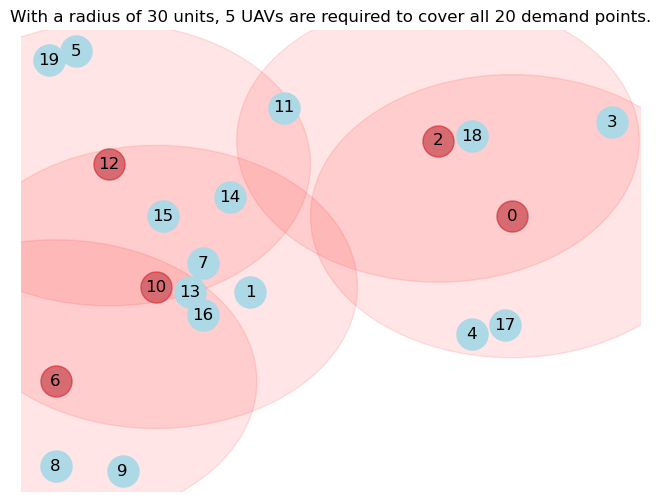

In [382]:
solution = []
if model.status == gb.GRB.OPTIMAL:
    print("Optimization successful.")
    print("Radius: {} units \nUAVs: {} \nDemand points: {}".format(coverage_radius, int(model.objVal), num_demand_points))
    for node in G.nodes():
        if x[node].x > 0.1:
            solution.append(node)
    # Create a new graph for visualization
    graph_visualization = nx.Graph()

    # Add nodes for demand points
    for node, demand_point in enumerate(demand_points):
        graph_visualization.add_node(node, pos=demand_point)

    # Add edges between demand points covered by the solution
    for node in solution:
        graph_visualization.add_edges_from([(node, n) for n in G.neighbors(node) if n in solution])

    # Draw the graph
    pos = nx.get_node_attributes(graph_visualization, 'pos')
    fig, ax = plt.subplots(figsize=figsize)  # Adjust the figure size as desired
    nx.draw(graph_visualization, pos, node_color='lightblue', ax=ax, node_size=node_size)


    # Highlight the demand points covered by the solution
    nx.draw_networkx_labels(G, pos, font_size=label_font_size)
    nx.draw_networkx_nodes(graph_visualization, pos, nodelist=solution, node_color='r', alpha=0.5, ax=ax, node_size=node_size)

    # Draw circles for coverage radius for covered demand points only
    for node in solution:
        if node in graph_visualization.nodes():
            x, y = pos[node]
            circle = plt.Circle((x, y), coverage_radius, alpha=0.1, color='r')
            ax.add_artist(circle)

    plt.title("With a radius of {} units, {} UAVs are required to cover all {} demand points.".format(coverage_radius, int(model.objVal), num_demand_points))
    plt.show()
else:
    print("No feasible solution found. Optimization status:", model.status)